# Generalized MLM distribution simulation

In [1]:
library(evd)
library(maxstablePCA)
library(ggplot2)
library(dplyr)
library(GGally)
library(graphicalExtremes)
library(Matrix)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2



### setup parameters and simulate data

In [2]:
set.seed(86420)
s <- 100

In [3]:
Z <- rmvevd(10000, dep = .5, model = "log", d = 2, mar = c(1,1,1))

In [4]:
Z2 <- rmstable(10000, d = 2, par = matrix(c(0, .6, .6, 0), 2, 2))

In [5]:
A <- matrix(c(0.8, 0.05, 0.6, 0.45, 0.2, 0.95, 0.4, 0.55), 4, 2)
X <- t(maxmatmul(A, t(Z)))
X2 <- t(maxmatmul(A, t(Z2)))

In [6]:
A

0.80,0.20
0.05,0.95
0.60,0.40
0.45,0.55


In [7]:
Xtrafo <- transform_unitpareto(X)

# max-stable PCA for X

In [8]:
summary(apply(Xtrafo, 1, max))

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
    1.000     1.580     2.562    13.786     5.308 10000.000 

In [9]:
length(which(apply(Xtrafo, 1, max) > s))

[1] 141

In [10]:
maxPCA1 <- max_stable_prcomp(Xtrafo, p = 1, s = s, n_initial_guesses = 15000, norm = "linfty")
maxPCA2 <- max_stable_prcomp(Xtrafo, p = 2, s = s, n_initial_guesses = 15000, norm = "linfty")
maxPCA3 <- max_stable_prcomp(Xtrafo, p = 3, s = s, n_initial_guesses = 15000, norm = "linfty")
maxPCA4 <- max_stable_prcomp(Xtrafo, p = 4, s = s, n_initial_guesses = 15000, norm = "linfty")

### inspect relevant output 

In [11]:
maxPCA2

$p
[1] 2

$d
[1] 4

$decoder_matrix
            [,1]      [,2]
[1,] 1.113205334 0.1178866
[2,] 0.004055144 1.0324646
[3,] 0.943135665 0.5481915
[4,] 0.726003414 0.7855713

$encoder_matrix
           [,1]      [,2]      [,3]       [,4]
[1,] 0.89830691 0.1493983 0.1277844 0.10263591
[2,] 0.02084733 0.9685562 0.0318197 0.07499711

$reconstr_matrix
           [,1]      [,2]       [,3]       [,4]
[1,] 1.00000005 0.1663109 0.14225032 0.11425484
[2,] 0.02152413 1.0000000 0.03285272 0.07743186
[3,] 0.84722529 0.5309542 0.12051806 0.09679959
[4,] 0.65217389 0.7608700 0.09277194 0.07451402

$loss_fctn_value
[1] 0.09400289

$optim_conv_status
[1] 4

$s
[1] 100

$starting_vals
$starting_vals$decoder_matrix_x0
          [,1]      [,2]
[1,] 1.0000000 0.3224842
[2,] 0.9329724 1.0000000
[3,] 0.8991738 0.4720304
[4,] 0.4290549 0.8517225

$starting_vals$encoder_matrix_x0
          [,1]      [,2]      [,3]      [,4]
[1,] 0.9176525 0.1697999 0.5183002 0.1026359
[2,] 0.7946069 0.9461765 0.2165304 0.9791701

In [12]:
maxPCA3$optim_conv_status

[1] 4

### report rounded estimated matrices

In [13]:
round(maxPCA2$decoder_matrix, 2)

1.11,0.12
0.00,1.03
0.94,0.55
0.73,0.79


In [14]:
round(maxPCA2$encoder_matrix, 2)

0.90,0.15,0.13,0.10
0.02,0.97,0.03,0.07


In [15]:
round(maxPCA2$reconstr_matrix, 2)

1.00,0.17,0.14,0.11
0.02,1.00,0.03,0.08
0.85,0.53,0.12,0.10
0.65,0.76,0.09,0.07


#### rescale the matrices such that the largest rowwise entries of $\hat W$ are equal to one

In [16]:
round(maxmatmul(maxPCA2$decoder_matrix, diag(apply(maxPCA2$encoder_matrix, 1, max))), 2)

1.00,0.11
0.00,1.00
0.85,0.53
0.65,0.76


In [17]:
round(t(apply(maxPCA2$encoder_matrix, 1, function(z) z / max(z))), 2)

1.00,0.17,0.14,0.11
0.02,1.00,0.03,0.08


# Elbow plot for reconstruction error 

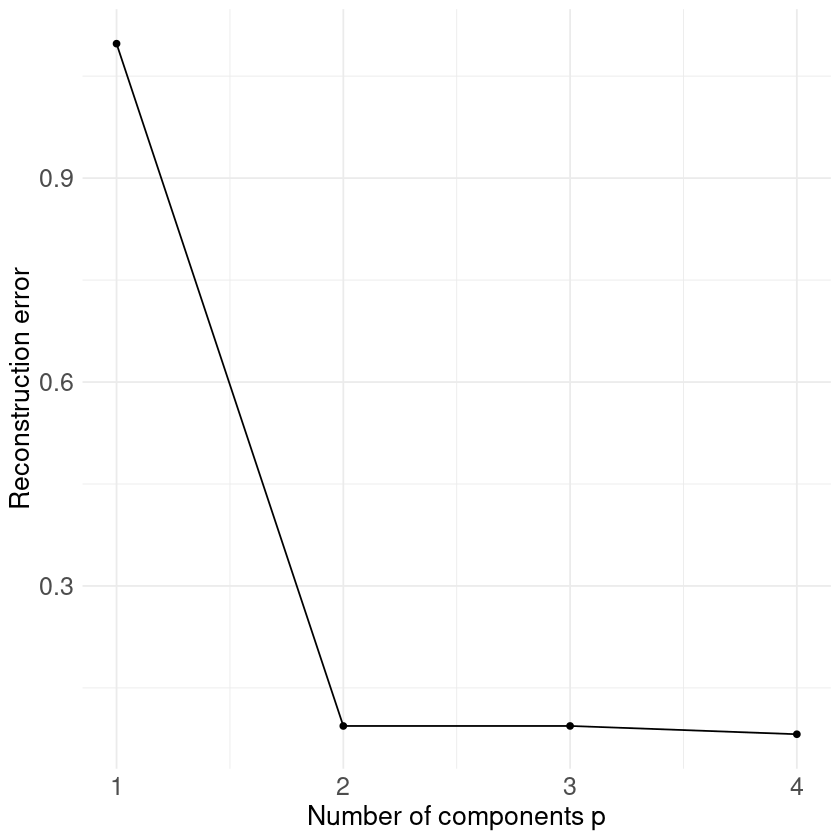

In [18]:
plotdat <- data.frame(p = 1:4, losses = c(
    maxPCA1$loss_fctn_value,
    maxPCA2$loss_fctn_value,
    maxPCA3$loss_fctn_value,
    maxPCA4$loss_fctn_value   
))

pe <- ggplot(aes(x = p, y = losses), data = plotdat) + 
geom_line() + 
geom_point() + 
ylab("Reconstruction error") + 
xlab("Number of components p") + 
theme_minimal() + 
theme(
    axis.title = element_text(size = 16),
    axis.text.x = element_text(size = 15),
    axis.text.y = element_text(size = 15)
)

pe

In [19]:
ggsave("genmlm_elbow.pdf", pe)

Saving 7 x 7 in image


# pairplot to visually inspect reconstruction

In [20]:
datX <- data.frame(X)
rec <- t(maxmatmul(maxPCA2$reconstr_matrix, t(as.matrix(datX))))
datX$is_rec = "original"
datrec <- data.frame(rec)
datrec$is_rec = "reconstruction"
names(datrec) <- names(datX)
plot_datX <- full_join(datX, datrec)

Joining with `by = join_by(X1, X2, X3, X4, is_rec)`


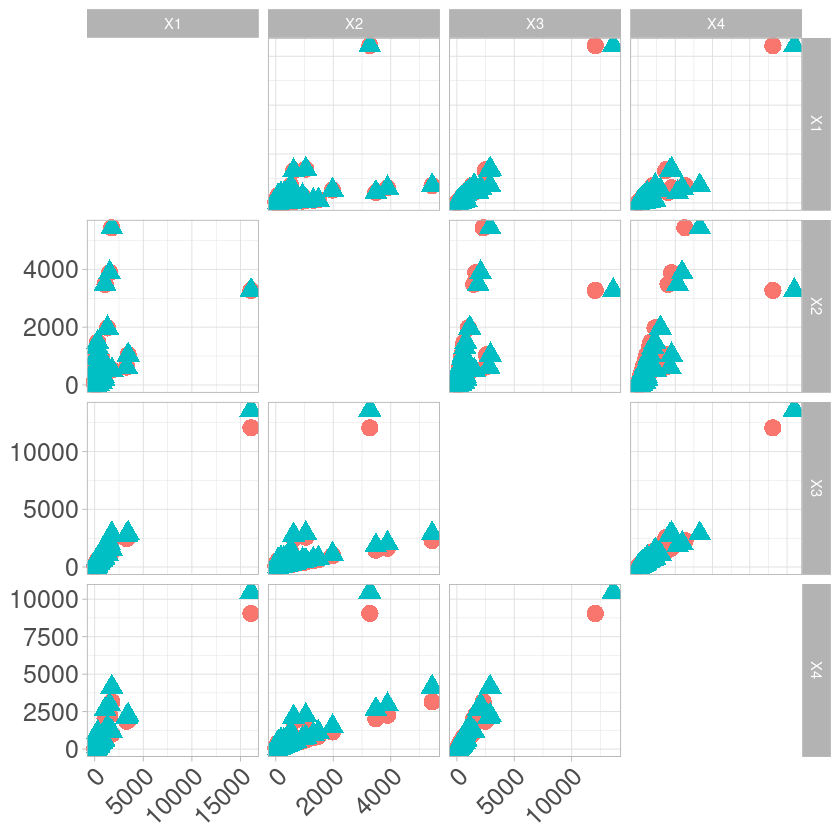

In [21]:
p <- ggpairs(
    plot_datX, 
    aes(color = is_rec, shape = is_rec, size = 2),
    columns = 1:4,
    upper = list(continuous = "points", combo = "dot_no_facet"),
    diag = list(continuous = "blankDiag", discrete = "barDiag", na = "naDiag")
) + 
theme_light() +
  theme(
    axis.text.x = element_text(size = 15),
    axis.text.y = element_text(size = 15)
  ) + 
theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1))

p

In [22]:
plot_datX %>% group_by(is_rec) %>% summarize(max(X1))

is_rec,max(X1)
<chr>,<dbl>
original,16083.69
reconstruction,16083.69


In [23]:
ggsave("genmlm.png", p)

Saving 7 x 7 in image
